# Danilo Montalvo
# Link: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [110]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib

import itertools

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import IsolationForest

import warnings

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"
device_lib.list_local_devices()
import sys
sys.path.insert(0, '..')

%matplotlib inline

## Loading the Data

In [111]:
# Load the datasets
train_data = pd.read_csv('/Users/danilomontalvo/Desktop/CNNHousing/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/Users/danilomontalvo/Desktop/CNNHousing/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('/Users/danilomontalvo/Desktop/CNNHousing/house-prices-advanced-regression-techniques/sample_submission.csv')  # Adjust the filename if necessary

# Display the first few rows of the training dataset
print(train.head())
train_data.head()

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [112]:
# Excluding columns which have majority as null
train_data= train_data.loc[:, train_data.isnull().sum()/len(train_data)<0.80]

x= train_data.iloc[:, 1:-1] # Dropping 'Id' and the Y feature
y= train_data.iloc[:,-1]

train_cols= x.columns
print(train_data.shape, x.shape, y.shape)

(1460, 77) (1460, 75) (1460,)


In [113]:
train_stats= x.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [114]:
ordinal_cols= list(x.columns[x.columns.str.contains('Yr|Year')])
print('ordinal/temporal columns:\n',ordinal_cols)
nominal_cols= list(set(x.select_dtypes(include=['object']).columns)- set(ordinal_cols))
print('nominal columns:\n', nominal_cols)
numeric_cols= list(set(x.select_dtypes(exclude=['object']).columns)- set(ordinal_cols))
print('numeric columns:\n',numeric_cols)

ordinal/temporal columns:
 ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
nominal columns:
 ['Utilities', 'Street', 'BsmtFinType1', 'GarageQual', 'Foundation', 'MSZoning', 'Condition1', 'BldgType', 'Functional', 'LandSlope', 'ExterQual', 'KitchenQual', 'BsmtFinType2', 'SaleCondition', 'Condition2', 'GarageFinish', 'LotShape', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'RoofMatl', 'BsmtExposure', 'MasVnrType', 'SaleType', 'BsmtQual', 'GarageType', 'Heating', 'LandContour', 'CentralAir', 'PavedDrive', 'HeatingQC', 'ExterCond', 'RoofStyle', 'Exterior2nd', 'Electrical', 'GarageCond', 'LotConfig', 'FireplaceQu', 'BsmtCond']
numeric columns:
 ['OverallQual', 'LotFrontage', 'BedroomAbvGr', 'MoSold', 'HalfBath', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'KitchenAbvGr', '2ndFlrSF', 'BsmtUnfSF', 'MSSubClass', 'GrLivArea', 'GarageArea', 'TotRmsAbvGrd', 'TotalBsmtSF', 'LowQualFinSF', 'OpenPorchSF', 'GarageCars', 'MasVnrArea', '3SsnPorch', 'MiscVal', 'FullBath', 'Fireplaces', 'WoodDeck

In [115]:
#Checking unique values
x[nominal_cols].describe().transpose()

,count,unique,top,freq
Utilities,1460,2,AllPub,1459
Street,1460,2,Pave,1454
BsmtFinType1,1423,6,Unf,430
GarageQual,1379,5,TA,1311
Foundation,1460,6,PConc,647
MSZoning,1460,5,RL,1151
Condition1,1460,9,Norm,1260
BldgType,1460,5,1Fam,1220
Functional,1460,7,Typ,1360
LandSlope,1460,3,Gtl,1382


In [116]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.20, random_state=0)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1168, 75), (292, 75), (1168,), (292,))

In [117]:
#find number of missing values in each category  

def missing_val_imputation(x, ordinal_cols,nominal_cols,numeric_cols):
    
    for col in ordinal_cols:
        x.loc[:,col]= x.loc[:,col].fillna(x.loc[:,col].mean())

    x.loc[:,nominal_cols]= x.loc[:,nominal_cols].fillna("?")
    
    for col in numeric_cols:
        x.loc[:,col]= x.loc[:,col].fillna(x.loc[:,col].mean())
#         x.loc[:,col]= x.groupby("OverallQual")[col].transform(lambda grp:grp.fillna(np.mean(grp)))

    print("All missing values are now imputed!\n",x.isnull().sum().sort_values(ascending=False))
    
    return x



In [118]:
#Fİnding # of missing values in train and test splits

x_train= missing_val_imputation(x_train,ordinal_cols,nominal_cols,numeric_cols)
x_test= missing_val_imputation(x_test,ordinal_cols,nominal_cols,numeric_cols)

All missing values are now imputed!
 MSSubClass       0
GarageType       0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 75, dtype: int64
All missing values are now imputed!
 MSSubClass       0
GarageType       0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 75, dtype: int64


### Analysis of Temporal Variables

In [119]:
from sklearn.preprocessing import OneHotEncoder
# Fitting OHE object
ohe= OneHotEncoder(handle_unknown='ignore', sparse=False).fit(x_train[nominal_cols]) 

#Feature Encoding for nominal columns

def ohe_transform(x, ohe, nominal_cols):
    x_ohe= pd.DataFrame(ohe.transform(x[nominal_cols]))
    x_ohe.columns=ohe.get_feature_names(nominal_cols)

    # prepping x
    x=x.drop(nominal_cols, axis=1)
    x.reset_index(inplace=True, drop=True)
    x= x.merge(x_ohe, left_index=True, right_index=True)
    
    return x

x_train= ohe_transform(x_train, ohe, nominal_cols)
x_test= ohe_transform(x_test, ohe, nominal_cols)
x_train.shape, x_test.shape

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


((1168, 283), (292, 283))

In [120]:
from sklearn.preprocessing import StandardScaler

# Standard Scaling
ss= StandardScaler()
x_train_ss= pd.DataFrame(ss.fit_transform(x_train))
x_test_ss= pd.DataFrame(ss.transform(x_test))
x_train.shape, x_train_ss.shape, x_test_ss.shape, y_train.shape

((1168, 283), (1168, 283), (292, 283), (1168,))

### Feature selection

In [121]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

sel= SelectFromModel(Lasso(alpha=0.5, max_iter=3000, tol=0.005, random_state=0, warm_start= False)) # warm_start= True

# train the lasso model and select features
sel.fit(x_train_ss, y_train)

sel.get_support()

selected_feats= x_train_ss.columns[(sel.get_support())]

# print the stats
print("# of total features: ",x_train.shape[1])
print("# of selected features: ",len(selected_feats))
# print("# of rejected features: ",np.sum(sel.estimator_.coef_==0))
# print('Selected features:', selected_feats)

x_train_ss= x_train_ss[selected_feats]
x_test_ss= x_test_ss[selected_feats]

x_train_ss.shape, x_test_ss.shape

# of total features:  283
# of selected features:  271


((1168, 271), (292, 271))

In [122]:

x_train.columns[10]
x_train['BsmtUnfSF']

0       1774
1        894
2        163
3        350
4       1541
        ... 
1163      89
1164     625
1165       0
1166    1374
1167    1195
Name: BsmtUnfSF, Length: 1168, dtype: int64

In [123]:
x_train_ss[10]

0       2.757198
1       0.745229
2      -0.926076
3      -0.498533
4       2.224484
          ...   
1163   -1.095265
1164    0.130207
1165   -1.298748
1166    1.842667
1167    1.433414
Name: 10, Length: 1168, dtype: float64

### Now it's time for the Neural Network Model


In [124]:
# Build  neural network
import keras

optimizer= tf.keras.optimizers.Adam(0.001)

normal_model = Sequential()
normal_model.add(Dense(128, input_shape=[len(x_train_ss.keys())], kernel_initializer='normal', activation='relu'))
normal_model.add(Dense(64, kernel_initializer='normal', activation='relu'))
normal_model.add(Dense(32, kernel_initializer='normal', activation='relu'))
normal_model.add(Dense(1, kernel_initializer='normal'))
normal_model.compile(loss='mse', optimizer = optimizer, metrics=['mean_absolute_error','mean_squared_error'])

# Build and inspect the model

normal_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               34816     
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 45,185
Trainable params: 45,185
Non-trainable params: 0
_________________________________________________________________


### Model Training and Evaluation

In [125]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history= normal_model.fit(
    x_train_ss, y_train,
    epochs=200,
    validation_data=(x_test_ss, y_test),
    verbose=0, #set verbose=1 for full details at every epoch
    callbacks= [early_stopping_cb])

loss, mae, mse= normal_model.evaluate(x_test_ss, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) # test mae- 36286

Epoch 68: early stopping
10/10 - 0s - loss: 3682392064.0000 - mean_absolute_error: 30489.4355 - mean_squared_error: 3682392064.0000 - 26ms/epoch - 3ms/step
Test-set Mean absolute error: 30489.44


In [126]:
loss, mae, mse= normal_model.evaluate(x_test_ss, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) # test mae- 36286

10/10 - 0s - loss: 3682392064.0000 - mean_absolute_error: 30489.4355 - mean_squared_error: 3682392064.0000 - 25ms/epoch - 3ms/step
Test-set Mean absolute error: 30489.44


Text(0.5, 1.0, 'Train - MAE')

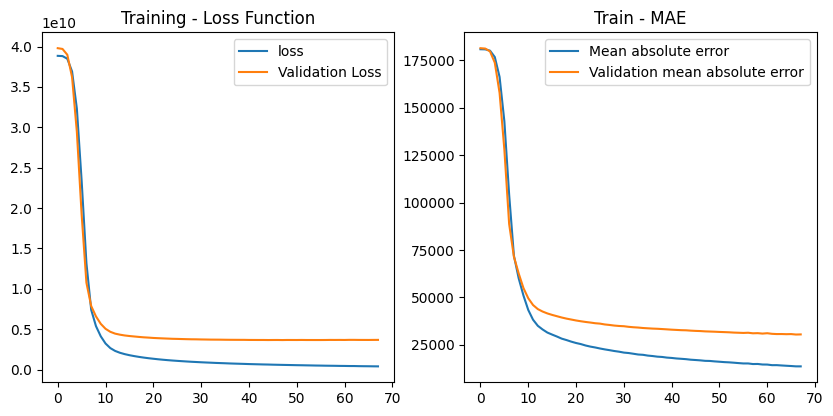

In [127]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Mean absolute error')
plt.plot(history.history['val_mean_absolute_error'], label='Validation mean absolute error')
plt.legend()
plt.title('Train - MAE')

10/10 [==============================] - 0s 2ms/step


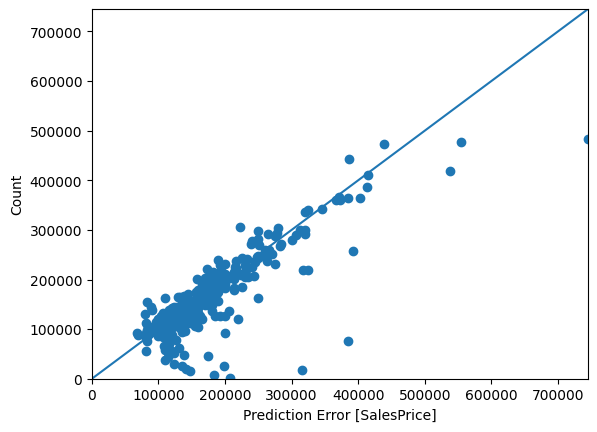

In [128]:
y_pred_test= normal_model.predict(x_test_ss).flatten()

# a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values [SalesPrice]')
plt.ylabel('Predictions [SalesPrice]')

lims=[0, max(y_test)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

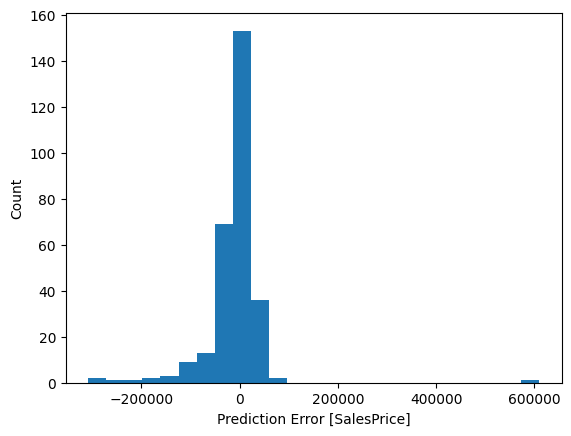

In [129]:
error= y_pred_test-y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SalesPrice]')
_=plt.ylabel('Count')

In [130]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Accuracy metrics :
y_pred_train= normal_model.predict(x_train_ss).flatten()

print("Accuracy obtained using x_train and x_val sets from the original x!")

print("Training accuracy: ",r2_score(y_train, y_pred_train))

print("Test accuracy: ",r2_score(y_test, y_pred_test))

print("Test mean-squared error: ",np.sqrt(mean_squared_error(y_test, y_pred_test)))

37/37 [==============================] - 0s 1ms/step
Accuracy obtained using x_train and x_val sets from the original x!
Training accuracy:  0.9362490423253288
Test accuracy:  0.4667720670211355
Test mean-squared error:  60682.716664366526


## Building the Neural Network Model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               34816     
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 1)                 33        
                                                                 
Total params: 45,185
Trainable params: 45,185
Non-trainable params: 0
_________________________________________________________________
Epoch 77: early stopping
10/10 - 0s - loss: 3793630720.0000 - mean_absolute_error: 29970.1504 - mean_squared_error: 3793630720.0000 - 30ms/epoch - 3ms/step
Test-set Mean absolute er

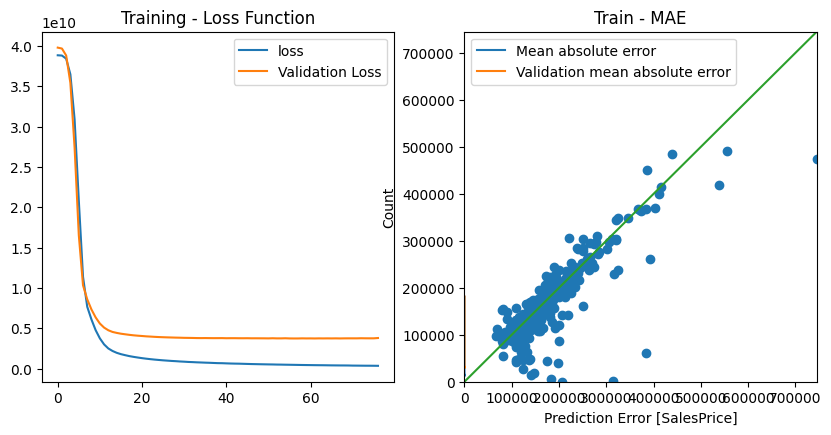

In [131]:
# Neural Network Model

# Build neural network
import keras

optimizer = tf.keras.optimizers.Adam(0.001)

normal_model = Sequential()
normal_model.add(Dense(128, input_shape=[len(x_train_ss.keys())], kernel_initializer='normal', activation='relu'))
normal_model.add(Dense(64, kernel_initializer='normal', activation='relu'))
normal_model.add(Dense(32, kernel_initializer='normal', activation='relu'))
normal_model.add(Dense(1, kernel_initializer='normal'))
normal_model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])

# Build and inspect the model
normal_model.summary()

# Model Training and Evaluation
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history = normal_model.fit(
    x_train_ss, y_train,
    epochs=200,
    validation_data=(x_test_ss, y_test),
    verbose=0,  # set verbose=1 for full details at every epoch
    callbacks=[early_stopping_cb])

loss, mae, mse = normal_model.evaluate(x_test_ss, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae))  # test mae- 36286

# Evaluate the model
print("Test-set Mean absolute error: {:5.2f}".format(mae))  # test mae- 36286

# Plot training history
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Mean absolute error')
plt.plot(history.history['val_mean_absolute_error'], label='Validation mean absolute error')
plt.legend()
plt.title('Train - MAE')

# Visualize the predictions
y_pred_test = normal_model.predict(x_test_ss).flatten()

plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values [SalesPrice]')
plt.ylabel('Predictions [SalesPrice]')

lims = [0, max(y_test)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Plot prediction error histogram
error = y_pred_test - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SalesPrice]')
_ = plt.ylabel('Count')

# Calculate accuracy metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred_train = normal_model.predict(x_train_ss).flatten()

print("Accuracy obtained using x_train and x_val sets from the original x!")

print("Training accuracy: ", r2_score(y_train, y_pred_train))

print("Test accuracy: ", r2_score(y_test, y_pred_test))

print("Test mean-squared error: ", np.sqrt(mean_squared_error(y_test, y_pred_test)))
